In [1]:
import pandas as pd
import numpy as np
import scipy.linalg as la
import scipy.stats as stats
# import statsmodels.api as sm
from sklearn import linear_model, model_selection, metrics
import sklearn
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import pprint

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Introduction

The United States' criminal justice system is a large complicated machine that seeks to deliver justice when an offense has been committed. This system has been slowly evolving as our society and culture have been changing. Many things that Americans take as natural in our criminal justice systems are quite abnormal among justice systems worldwide. Since the 1990s, America has seen a drastic increase in the incarcerated population, despite a sharp decrease in crime [[1](https://www.nytimes.com/2008/04/23/world/americas/23iht-23prison.12253738.html)]. Many Americans may believe that this drastic increase in incarceration is a result of increased rates of crime, and that this heightened rate is natural and just. To many, it is unclear who is most affected by this drastic change in the application of justice in America, and even more unclear is how they are so affected.

There is a lot of existing research exploring incarceration and the criminal justice system. There is a consensus that America incarcerates a larger proportion of its population than any other nation and that people of color are disproportionately affected by this high incarceration rate [[2](https://www.nytimes.com/2008/04/23/world/americas/23iht-23prison.12253738.html)].

In this project I am interested in exploring the ways in which the law is being applied differently to people in America. I will explore different ways to quantify claims about mass incarceration and racial bias. I will also be examining things that factor into sentence length including the offense committed and race. There are many things that contribute to sentence length, however the scope of this project is limited to these factors.

# Data
## Source and Credibility
The data that I will be using in this analysis is gathered from primarily two sources. The first is the Bureau of Justice Statistics and the second is a link to a [database](https://catalog.data.gov/dataset/sentenced-inmates-in-correctional-facilities) hosted on [Data.gov](https://www.data.gov) and maintained by the State of Connecticut Department of Corrections. These are highly credible sources because they are primary sources for the data. These organizations are official government agencies which collect, maintain, and report on this data.

## Gathering and Cleaning
All the data which I am using in this report are freely available to the public. Collection and cleaning was relatively simple as the source data was well maintained. The data that I collected from the Bureau of Justice Statistics (BJS) needed to be formatted in a way that is easily read by the Python packages I will be using. This data was prepared in .xlsx files as to be easily human readable, however this is not generally easily ingested by programs. I extracted data that I found to be relevant into separate .csv files and kept the original files for reference. The files are
```
incarceration_counts.csv
incarceration_by_race.csv
crime_data.csv.
```

The file that I obtained from the Connecticut Department of Corrections is a very well maintained database. The largest issue I had with this file was mild inconsistency with the way in which certain data was encoded (ex. race was encoded as both `WHITE` and `WHITE\t`). This was the data that I spent the most time working to engineer as it is a data set that I intend to use for different regression-related analyses. The files are
```
individuals.csv
regression_df.csv.

```

## Contents
### Bureau of Justice Statistics Data
Here I will describe generally each data file and its contents, as well as give a small sample from each file [3,4,5].

In [3]:
incar = pd.read_csv('../data/incarceration_trends.csv')
race = pd.read_csv('../data/incarceration_by_race.csv')
crime = pd.read_csv('../data/crime_data.csv')

First we will examine `incarceration_trends.csv`.
This data set records total jail and prison populations across the United States over time. This is useful in understanding general trends in the U.S. over time. The prison population columns are raw populations of incarcerated individuals while the "population" column is the U.S. population in millions for that year.

In [4]:
print(incar[['Year','State prisons','Population']].sample(3))

    Year  State prisons  Population
24  1949         146881      149.19
61  1986         485553      240.13
75  2000        1209130      282.16


`incarceration_by_race.csv` contains race demographic data for incarcerated populations by institution. This will allow us to understand state incarcerated populations.

In [5]:
race['White_rate']
cols = ['Geography','Total','White','Black','White_rate','Black_rate']
print(race[cols].sample(2))


       Geography  Total  White  Black  White_rate  Black_rate
42  South Dakota   6327   3708    476         530        4663
3        Arizona  67767  36160   8246         775        3184


`crime_data.csv` records crime rates over time in this U.S. This data set will help us understand how crime relates to incarceration. The rates are given in offense per 100,000.

In [6]:
cols = ['Year','Violent crime','Murder','Rape','Robbery','Assault']
print(crime[cols].sample(3))

    Year  Violent crime  Murder  Rape  Robbery  Assault
46  2006          473.6     5.8  31.6    150.0    292.0
37  1997          611.0     6.8  35.9    186.2    382.1
9   1969          328.7     7.3  18.5    148.4    154.5


### Connecticut Department of Corrections Data

This data set contains individual information for 7.77 million people that have been processed by the justice system and recorded by the Connecticut Department of Corrections. Each individual is recorded along with their age, gender, race, offense, and sentence length, among other things [6].

I also created one-hot encoded versions of this data set in order to run regressions on the data. Because of the size of the data, the regression data sets are only random subsets of the larger data set.

Because there is so much to consider in what is found in the data set, I chose not to engineer more features as to avoid unneeded complexity.

In [5]:
inmates = pd.read_csv('../data/individuals.csv')
race_regr_df = pd.read_csv('../data/race_regression_df.csv')

In [8]:
cols = ['LATEST ADMISSION DATE','AGE','RACE','SENTENCE DAYS']
print(inmates[cols].sample(3))

        LATEST ADMISSION DATE  AGE   RACE  SENTENCE DAYS
4149965            06/22/2018   29  WHITE            731
7570861            01/31/2019   34  WHITE            548
3340323            02/02/2018   43  WHITE            548


We ought to disclose the sample sizes among different races that are found in the Connecticut Department of Justice data. The sample size for American Indians and Asians is much smaller than that of Whites, Hispanics, and Blacks, hence we may see some irregular outcomes in the analysis related to these racial groups.

In [6]:
races = {'BLACK':'Blacks','WHITE':'Whites',
         'HISPANIC':'Hispanic','AMER IND':'American Indian',
         'ASIAN':'Asian'
        }
for rac in races.keys():
    mask = inmates.RACE == rac
    print(f'Sample size for {races[rac]}: {len(inmates[mask])}')

Sample size for Blacks: 3287596
Sample size for Whites: 2393949
Sample size for Hispanic: 2039297
Sample size for American Indian: 21133
Sample size for Asian: 35660


# Analysis and Visualization
## Increased Rates
Here we can see the drastic increase of the amount of incarceration in the U.S. Something that is interesting to note is that jails are defined as places for people who have a sentence less than 1 year, or who are awaiting trial. So we see that at its peak in 2008, there were more people awaiting trial than there were being held in federal prison in 1991.

Here I have incarceration rates plotted against the violent crime rate in the United States. Near the beginning of the crime rate data we might assume some amount of inaccuracy, since the crime rate seems to be less than the incarceration rate, however there is an indisputable spike in crime rates in the 1980s and 1990s. Something to note is that the incarceration rate seems to lag behind about 20 years. Another thing to note is that there has been a strict decrease in violent crime (and in all crime) since the 90s, however we do not see the same decrease in the incarceration rate.

Some would argue that we see this decrease in crime because of the increase of incarceration. I would disagree. Consider the scales of the different curves we see on the chart. Both are in terms of the rate per 100,000, but the crime rate is more than 200 times higher than the incarceration rate in state prisons. Unless 0.5% of people who committed crime in the 90s were committing more than half of all crime, I would argue that there is some other cause for the decrease in crime rates.

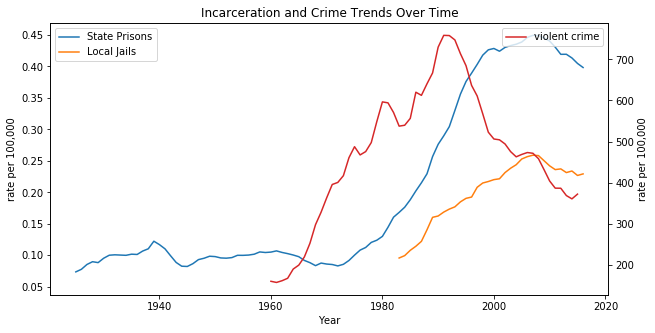

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(
    incar['Year'].values,
    incar['State prisons'].values / (incar.Population*10**4),
    label='State Prisons', color='tab:blue')

ax.plot(
    incar['Year'].values,
    incar['Local jails'].values / (incar.Population*10**4),
    label='Local Jails', color='tab:orange')
ax2 = ax.twinx()
ax2.plot(
    crime.Year, crime['Violent crime'],
    label='violent crime', color='tab:red'
)
ax2.set_ylabel('rate per 100,000')
ax2.legend()
ax.legend()
ax.set_title('Incarceration and Crime Trends Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('rate per 100,000')
plt.savefig('../tex/images/incar_trends.pdf',dpi=100)
plt.show()

## Artifacts of Prison Policy
One might expect sentence lengths to be distributed somewhat smoothly. However there are standard sentence lengths and mandatory minimum sentences that influence the distribution of sentence lenghts, making the distribution not smooth.

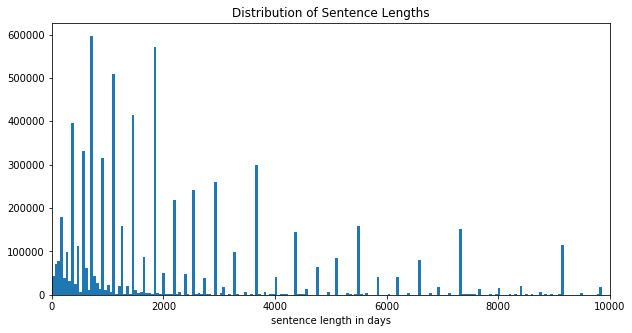

In [29]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.set_xlim(0,10000)
mask = inmates['SENTENCE DAYS'] < 10000
ax.hist(
    inmates['SENTENCE DAYS'][mask].values,
    bins=200
)
plt.xlabel('sentence length in days')
plt.title('Distribution of Sentence Lengths')
plt.savefig('../tex/images/sent_dist.pdf',dpi=100)
plt.show()

## Racial Disparities
In this section we will explore how the criminal justice system affects people of different races.

### Incarceration Disparity
These simple histograms, which plot the incarceration rates of Whites, Blacks, Hispanics, and Asians among the 50 states, show the huge racial disparity in incarceration in America. By incarceration rate we mean: of 100,000 people of a given race, how many are incarcerated? A simple examination of the x-axis, which is rate of incarceration shows that the histogram for Whites barely overlaps with the histograms for Blacks and Hispanics. This means that in states with a low incarceration rate for Blacks, the Black incarceration rate is higher than the highest rates seen among Whites.

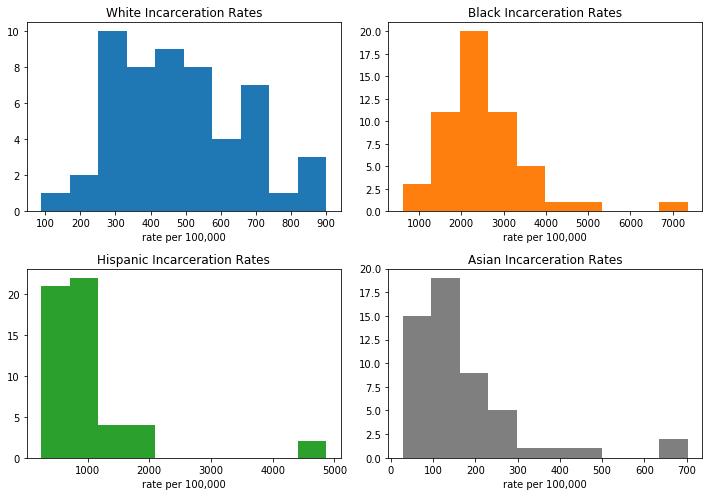

In [30]:
fig, ax = plt.subplots(2,2, figsize=(10,7))
ax[0,0].hist(race['White_rate'])
ax[0,0].set_title('White Incarceration Rates')
ax[0,0].set_xlabel('rate per 100,000')

ax[0,1].hist(race['Black_rate'], color='tab:orange')
ax[0,1].set_title('Black Incarceration Rates')
ax[0,1].set_xlabel('rate per 100,000')

ax[1,0].hist(race['Hisp_rate'], color='tab:green')
ax[1,0].set_title('Hispanic Incarceration Rates')
ax[1,0].set_xlabel('rate per 100,000')

ax[1,1].hist(race['Asian_rate'], color='tab:gray')
ax[1,1].set_title('Asian Incarceration Rates')
ax[1,1].set_xlabel('rate per 100,000')
fig.tight_layout()
plt.savefig('../tex/images/state_incar_rates.pdf',dpi=100)
plt.show()

### Distribution of Sentence Lengths
The next aspect we will explore in this section is the distribution of sentence lengths among people of different races. Here we are using the data of more than 7.7 million individuals processed by the criminal justice system. The medians are comparable on the scale at which sentence length is given. Asians and American Indians have the longest median sentence length, however the standard deviation in their sentence lengths is much less than what is seen in the other racial groups. I would attribute this to the low sample size of Asians and American Indians.

In [18]:
races = inmates.groupby(by='RACE')
print(
    'Median sentence lengths:\n {}'.format(races['SENTENCE DAYS'].median())
)
print('\n')
print(
    'Standard deviation of sentence lengths:\n {}'.format(races['SENTENCE DAYS'].std())
)

Median sentence lengths:
 RACE
AMER IND    2192
ASIAN       2557
BLACK       1826
HISPANIC    1826
WHITE       1461
Name: SENTENCE DAYS, dtype: int64


Standard deviation of sentence lengths:
 RACE
AMER IND     3208.584729
ASIAN        5122.011265
BLACK       37306.146883
HISPANIC    35763.282330
WHITE       46882.705552
Name: SENTENCE DAYS, dtype: float64


This box plot is where we begin to see the disparity in the way people of different races are sentenced. While the first two quartiles of each racial group's sentence lengths are similar, we see that the top two quartiles vary widely.

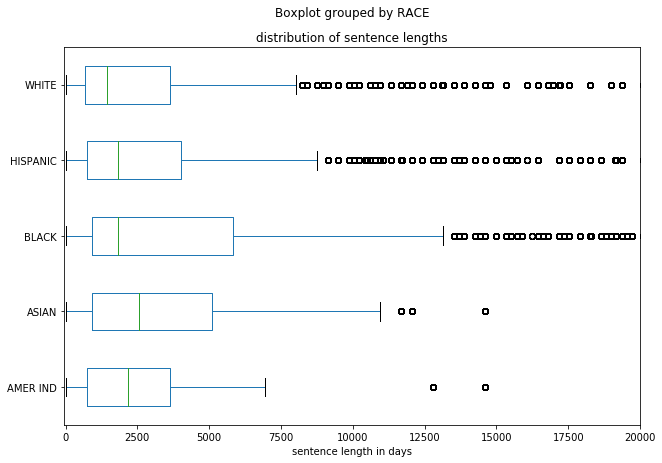

In [8]:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.set_xlim(-50,20000)
bp = inmates.boxplot(
    ['SENTENCE DAYS'], by=['RACE'],
    vert=False, grid=False,
    ax=ax
)
ax.set_title('distribution of sentence lengths')
ax.set_xlabel('sentence length in days')
plt.savefig('../tex/images/sentence_boxplot',dpi=300)
plt.show()

The following histograms will assist us in understanding these distributions.

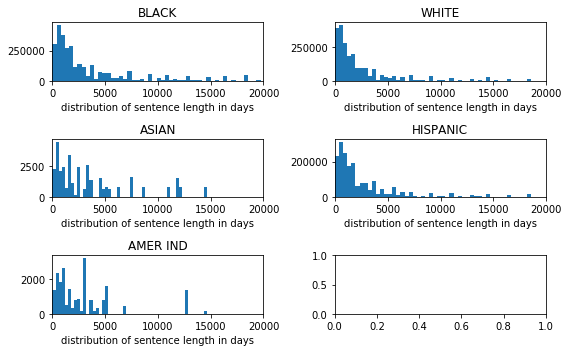

In [32]:
fig, ax = plt.subplots(3,2, figsize=(8,5))
indexer = {
    (0,0):'BLACK',
    (0,1):'WHITE',
    (1,0):'ASIAN',
    (1,1):'HISPANIC',
    (2,0):'AMER IND'
}
for key in indexer.keys():
    ax[key].set_xlim(-50,20000)
    mask = races.get_group(indexer[key])['SENTENCE DAYS'] < 20000
    ax[key].hist(
        races.get_group(indexer[key])['SENTENCE DAYS'][mask],
        bins=50
    )
    ax[key].set_xlabel('distribution of sentence length in days')
    ax[key].set_title(indexer[key])

fig.tight_layout()
plt.savefig('../tex/images/race_sentence_dist.pdf',dpi=100)
plt.show()

While it may appear that these sentences are distributed fairly equivalently, we can examine the kurtosis of the distribution to understand how much of the weight of the distribution is found in the extremities. Groups with high kurtosis have a higher probability of receiving a sentence that is far from the mean [[7](https://www.tandfonline.com/doi/full/10.1080/00031305.2014.917055?scroll=top&needAccess=true)].

As we can see, Blacks and Hispanics have the greatest kurtosis, meaning they are much more likely to receive an extreme sentence length. It is difficult to explain the small kurtosis in American Indians and Asians because of the small sample size.

In [16]:
out = '{} Kurtosis: {}'
kurts = {
    'White':
    stats.kurtosis(races.get_group('WHITE')['SENTENCE DAYS']),
    'Black':
    stats.kurtosis(races.get_group('BLACK')['SENTENCE DAYS']),
    'Hispanic':
    stats.kurtosis(races.get_group('HISPANIC')['SENTENCE DAYS']),
    'American Indian':
    stats.kurtosis(races.get_group('AMER IND')['SENTENCE DAYS']),
    'Asian':
    stats.kurtosis(races.get_group('ASIAN')['SENTENCE DAYS']),
}

for key in kurts.keys():
    print(
        out.format(key, kurts[key])
    )

White Kurtosis: 54.01344161453346
Black Kurtosis: 86.11479232153843
Hispanic Kurtosis: 96.03075354970996
American Indian Kurtosis: 4.0085627062942955
Asian Kurtosis: 7.45297417968173


### Predicting Sentence Length
As indicated by the regression below, attempting to predict sentence length based only on the race of the offender is not possible. A larger regression, contained in the appendix, shows that a simple linear regression does a decent job with an $R^2$ value of 0.52, when offenses are included as variables in the regression. It is inaccurate to claim that race alone is the biggest predictor of sentence length and unreasonable to claim race is more important than the offense when in comes to sentence length.

So how can we explore more deeply the relationship between race and sentence length?

In [17]:
race_regr_df.dropna(inplace=True)
sentence = race_regr_df['SENTENCE DAYS']
race_regr_df.drop(
    ['SENTENCE DAYS','Unnamed: 0'], axis=1, inplace=True
)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    race_regr_df.astype(float), sentence, test_size=.3
)
res_gen = sm.OLS(y_train, X_train).fit()
print('Regression Results:\n')
print(f'\tMethod: Least Squares')
print(f'\tR-squared value: {res_gen.rsquared}')
print(f'\tAIC: {res_gen.aic}')
print(f'\tBIC: {res_gen.bic}')

Regression Results:

	Method: Least Squares
	R-squared value: 0.03601534317319244
	AIC: 19410096.12270456
	BIC: 19410165.748789284


### Racial Disparity 
In the following section we will examine only individuals that have committed the same crime. Then, among those individuals we will examine distribution of sentence length. This will show how people of different races are treated differently, when in comparable situations.

We will begin by examining the distribution of sentence lengths among offenders convicted of "criminal liability for another person".

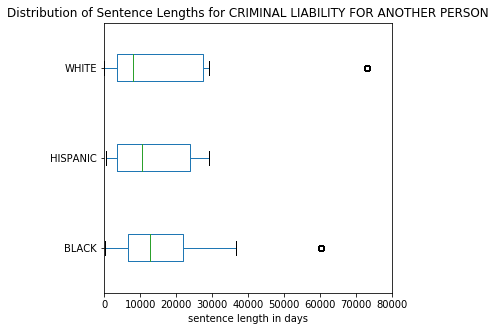

In [34]:
race_mask1 = inmates.RACE != 'AMER IND'
race_mask2 = inmates.RACE != 'ASIAN'
race_mask = np.logical_and(race_mask1,race_mask2)

mask = inmates[race_mask]['OFFENSE'] =='CRIMINAL LIABILITY FOR ANOTHER PERSON'

fig, ax = plt.subplots(1, figsize=(5,5))
ax.set_xlim(-50,80000)
bp = inmates[race_mask][mask].boxplot(
    ['SENTENCE DAYS'], by=['RACE'],
    vert=False, grid=False,
    ax=ax
)
plt.suptitle("")
ax.set_title('Distribution of Sentence Lengths for CRIMINAL LIABILITY FOR ANOTHER PERSON')
ax.set_xlabel('sentence length in days')
plt.savefig('../tex/images/crim_lib_box.pdf',dpi=100)
plt.show()

Again we can notice that the distributions don't seem to be all that different. However, we can examine kurtosis to see if there is a significant difference between these distributions that is lost in a box plot.

In [32]:
mask = inmates[race_mask]['OFFENSE'] == 'CRIMINAL LIABILITY FOR ANOTHER PERSON'


out = '{} Kurtosis for\n\t{}: {}'
kurts = {
    'White':
    stats.kurtosis(
        races.get_group('WHITE')['SENTENCE DAYS'][race_mask][mask]
    ),
    'Black':
    stats.kurtosis(
        races.get_group('BLACK')['SENTENCE DAYS'][race_mask][mask]
    ),
    'Hispanic':
    stats.kurtosis(
        races.get_group('HISPANIC')['SENTENCE DAYS'][race_mask][mask]
    )
#     'American Indian':
#     stats.kurtosis(races.get_group('AMER IND')['SENTENCE DAYS'][mask]),
#     'Asian':
#     stats.kurtosis(races.get_group('ASIAN')['SENTENCE DAYS'][mask]),
}

for key in kurts.keys():
    print(
        out.format(key, 'CRIMINAL LIABILITY FOR ANOTHER PERSON', kurts[key])
)

White Kurtosis for
	CRIMINAL LIABILITY FOR ANOTHER PERSON: 12.421485976410926
Black Kurtosis for
	CRIMINAL LIABILITY FOR ANOTHER PERSON: 23.752981544095174
Hispanic Kurtosis for
	CRIMINAL LIABILITY FOR ANOTHER PERSON: 0.5345890525784038


Here it is made clear that Blacks and Hispanics are much more likely to receive an extreme sentence than other racial groups for the crime of criminal liability.

Following is a sample of a few offenses, the distributions of sentence lengths, and the kurtosis of those distributions.

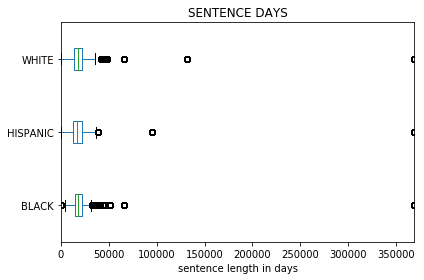

AttributeError: 'dict' object has no attribute 'get_group'

In [7]:
# offenses = set(inmates.OFFENSE.sample(5))
race_mask1 = inmates.RACE != 'AMER IND'
race_mask2 = inmates.RACE != 'ASIAN'
race_mask = np.logical_and(race_mask1,race_mask2)
offenses = [
    'MURDER                                AF',
    'SALE OF CONTROLLED SUBSTANCE           F',
    'SALE OF HALLUCIGEN/NARCOTIC SUBSTANCE  F',
    'ROBBERY, FIRST DEGREE                 BF'
#     'CRIMINAL LIABILITY FOR ANOTHER PERSON'
]
for off in offenses:
    
    mask = inmates[race_mask]['OFFENSE'] == off
    # inmates[mask]['RACE'].sample(10)
    fig, ax = plt.subplots(1)
    lim = np.percentile(
        inmates['SENTENCE DAYS'][race_mask][mask],
        98
    )
    ax.set_xlim(-50,lim)
    bp = inmates[race_mask][mask].boxplot(
        ['SENTENCE DAYS'], by=['RACE'],
        vert=False, grid=False,
        ax=ax
    )
    plt.suptitle("")
#     ax.set_title(f'distribution of sentence lengths for {off}')
    ax.set_xlabel('sentence length in days')
    fig.tight_layout()
    plt.savefig(f'../tex/images/{off[:10]}_box.pdf',dpi=100)
    plt.show()
    out = '{} Kurtosis: {}'
    kurts = {
        'White':
        stats.kurtosis(
            races.get_group('WHITE')['SENTENCE DAYS'][race_mask][mask]
        ),
        'Black':
        stats.kurtosis(
            races.get_group('BLACK')['SENTENCE DAYS'][race_mask][mask]
        ),
        'Hispanic':
        stats.kurtosis(
            races.get_group('HISPANIC')['SENTENCE DAYS'][race_mask][mask]
        )
#         'American Indian':
#         stats.kurtosis(races.get_group('AMER IND')['SENTENCE DAYS'][mask]),
#         'Asian':
#         stats.kurtosis(races.get_group('ASIAN')['SENTENCE DAYS'][mask]),
    }

    for key in kurts.keys():
        print(
            out.format(key, kurts[key])
    )

Here we can see that in many cases Blacks and Hispanics are treated differently when it comes to sentencing and incarceration.

# Conclusion

The American criminal justice system had been criticized by many. Some claim that it is an extension of slavery, others claim that is biased and broken, while still others claim that it is effective [[8](https://museumandmemorial.eji.org/museum)]. Dozens of organizations study the American prison system with the goal of reforming it, while private, for profit, prisons lobby to maintain the status quo. We have explored a few of the ways in which the American criminal justice system is biased, though understanding the biases is only the first step to formulating sound policy that can affect positive change. I hope the facts and opinions presented in this report become impetus to research further and understand the ways in which American society continues to disenfranchise Americans of color today.